# Example: Properties

#### Imports

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import dxtb

#### Functions

In [158]:
def fold(
    frequencies,
    intensities,
    start=800.0,
    end=4000.0,
    npts=None,
    width=4.0,
    type="Gaussian",
    normalize=True,
):
    """
    Fold frequencies and intensities within the given range
    and folding method (Gaussian/Lorentzian).
    The energy unit is cm^-1.
    normalize=True ensures the integral over the peaks to give the
    intensity.
    
    Taken from https://wiki.fysik.dtu.dk/ase/_modules/ase/vibrations/vibrations.html#Vibrations.fold
    """

    lctype = type.lower()
    assert lctype in ["gaussian", "lorentzian"]

    if not npts:
        npts = int((end - start) / width * 10 + 1)

    prefactor = 1
    if lctype == "lorentzian":
        intensities = intensities * width * np.pi / 2.0
        if normalize:
            prefactor = 2.0 / width / np.pi
    else:
        sigma = width / 2.0 / np.sqrt(2.0 * np.log(2.0))
        if normalize:
            prefactor = 1.0 / sigma / np.sqrt(2 * np.pi)

    # Make array with spectrum data
    spectrum = np.empty(npts)
    energies = np.linspace(start, end, npts)
    for i, energy in enumerate(energies):
        energies[i] = energy
        if lctype == "lorentzian":
            spectrum[i] = (
                intensities
                * 0.5
                * width
                / np.pi
                / ((frequencies - energy) ** 2 + 0.25 * width**2)
            ).sum()
        else:
            spectrum[i] = (
                intensities * np.exp(-((frequencies - energy) ** 2) / 2.0 / sigma**2)
            ).sum()
    return [energies, prefactor * spectrum]


#### References

In [159]:
# from CCCBDB (calculated frequencies and vibrational properties for H2O)
HF_FREQ = np.array([3944.0, 3811.0, 1800.0])
HF_INTS = np.array([9.123e00, 4.7e-02, 7.989e01])

# xtb h2o/coord --gfn 1 --hess
REF_FREQ = np.array([1480.0601, 3643.9749, 3747.3581])
REF_INTS = np.array([232.8048, 45.4997, 45.5097])


#### dxtb calculation

In [160]:
f = Path(globals()['_dh'][0]) / "molecules" / "ch4.coord"
atoms, xyz = dxtb.io.read_coord(f)

In [161]:
device = torch.device("cpu")
dd: dxtb._types.DD = {"device": device, "dtype": torch.double}

numbers = torch.tensor(atoms, device=device)
positions = torch.tensor(xyz, **dd)
charge = torch.tensor(0.0, **dd)

# position gradient for intensities
positions.requires_grad_(True)

# dipole moment requires electric field
field_vector = torch.tensor([0.0, 0.0, 0.0], **dd)
ef = dxtb.external.new_efield(field_vector)

calc = dxtb.Calculator(numbers, dxtb.GFN1_XTB, interaction=[ef], **dd)
freqs, ints = calc.ir_spectrum(numbers, positions, chrg=charge)

freqs, ints = freqs.detach().numpy(), ints.detach().numpy()


iter  energy                   energy change  P norm change   charge change  
-----------------------------------------------------------------------------
  1   -4.3370858689397993E+00   9.698019E+00  2.599789E+00    1.219815E+00
  2   -4.3392358070381674E+00   2.149938E-03  8.726720E-02    8.587399E-02
  3   -4.3393055360547850E+00   6.972902E-05  1.782268E-02    1.758906E-02
  4   -4.3393059531623717E+00   4.171076E-07  1.818756E-03    1.815392E-03
  5   -4.3393059679797430E+00   1.481737E-08  1.806291E-04    1.609284E-04
  6   -4.3393059724394938E+00   4.459751E-09  1.379214E-04    1.294400E-04
  7   -4.3393059725455538E+00   1.060600E-10  2.327755E-05    2.190411E-05
  8   -4.3393059725459544E+00   4.005685E-13  1.449309E-06    1.366878E-06
-----------------------------------------------------------------------------
**********************Energy**********************

Contribution                 Energy in a.u.    
--------------------------------------------------
Repulsion     

1/15
2/15
3/15
4/15
5/15
6/15
7/15
8/15
9/15
10/15
11/15
12/15
13/15
14/15
15/15
  9   -4.3393060134343129E+00   4.088836E-08  1.515683E-06    1.402790E-06
 10   -4.3393059725455538E+00   4.088876E-08  3.567280E-07    1.034154E-07
 11   -4.3393059725455538E+00   0.000000E+00  0.000000E+00    0.000000E+00
 12   -4.3393059725455538E+00   0.000000E+00  0.000000E+00    0.000000E+00
 13   -4.3393059725455538E+00   0.000000E+00  0.000000E+00    0.000000E+00
 14   -4.3393059725455538E+00   0.000000E+00  0.000000E+00    0.000000E+00


#### Taxol

In [162]:
freqs_taxol = torch.tensor(
    [
        -3.2704268599032835e-03,
        -3.2704268599032835e-03,
        -3.2704268599032835e-03,
        -3.2704268599032835e-03,
        -3.2704268599032835e-03,
        -3.2704268599032835e-03,
        -3.2704268599032835e-03,
        8.7446778315920255e-03,
        4.2930841973373335e00,
        1.3156887076650854e01,
        3.5634388501909129e01,
        3.6867324265300738e01,
        4.1442815937347781e01,
        5.2841026456292724e01,
        5.6877068987398204e01,
        6.3871524960714474e01,
        6.5253616709056985e01,
        7.3758180716190111e01,
        7.5490715266591977e01,
        8.9765742326533385e01,
        9.1757844460791674e01,
        1.0197945140621860e02,
        1.0697204173330206e02,
        1.0833231645374373e02,
        1.2149790212041106e02,
        1.2764654155799302e02,
        1.3868428862914234e02,
        1.4006795657923607e02,
        1.4581205661814172e02,
        1.5519171879794544e02,
        1.5774368109756020e02,
        1.6289947779675657e02,
        1.6597012302071860e02,
        1.7548859411026706e02,
        1.8208242119380191e02,
        1.8637826329410410e02,
        1.9494511789678714e02,
        1.9911695970148395e02,
        2.0499298085197071e02,
        2.0713665120771796e02,
        2.1247317924271695e02,
        2.1806353311787694e02,
        2.3131651569748817e02,
        2.3887436731655012e02,
        2.4583767801692787e02,
        2.5013469212626742e02,
        2.5512880802165321e02,
        2.6233784628025171e02,
        2.7462057000551965e02,
        2.7651458338229094e02,
        2.8390542190298555e02,
        2.9383231217956393e02,
        3.0233927913561331e02,
        3.0611553507446058e02,
        3.1352928141830762e02,
        3.2193631170057370e02,
        3.2664735340227463e02,
        3.3110995228125137e02,
        3.3574466908448255e02,
        3.5006083780995226e02,
        3.5786858766087903e02,
        3.6121043190333432e02,
        3.6351298835170326e02,
        3.6388672424237086e02,
        3.6950773323879019e02,
        3.7254192020539108e02,
        3.7386958780517290e02,
        3.8505795482149841e02,
        3.8731780681665066e02,
        3.8912255766681028e02,
        3.9392506891591728e02,
        3.9629373900705468e02,
        4.0099548942203887e02,
        4.0870781788203641e02,
        4.1595059434853374e02,
        4.1824280129610361e02,
        4.2187200172955380e02,
        4.2725397250949834e02,
        4.3915126352339877e02,
        4.5567483636902051e02,
        4.6985507875825721e02,
        4.7507223729199643e02,
        4.8341119160363269e02,
        4.9390647861074063e02,
        5.0327016617988204e02,
        5.1395931422464923e02,
        5.1937032384726399e02,
        5.2763267493097567e02,
        5.3761631951657444e02,
        5.4035194165398855e02,
        5.4669145177830353e02,
        5.5720366564480582e02,
        5.6024434152210927e02,
        5.6660174632679355e02,
        5.7387005392937249e02,
        5.8089857582811590e02,
        5.8485316078768994e02,
        5.9051045980975005e02,
        5.9160933596725772e02,
        5.9202316829019503e02,
        5.9827995315675969e02,
        6.0884058239382171e02,
        6.1721672109495307e02,
        6.2740299761982499e02,
        6.3905255282076553e02,
        6.5132289354093598e02,
        6.5611254921869931e02,
        6.5965501883458762e02,
        6.6185794981396919e02,
        6.6622657334244684e02,
        6.7223956135978767e02,
        6.7847927628372599e02,
        6.8163471806392579e02,
        6.8977296688662545e02,
        6.9216667106941293e02,
        6.9931799508547590e02,
        7.3347429822775689e02,
        7.3905158415486915e02,
        7.5960599946926163e02,
        7.6107504203705071e02,
        7.7150050003856688e02,
        7.7602427424544226e02,
        7.7690181365782200e02,
        7.9112970820827729e02,
        7.9750046608073376e02,
        8.3242136998395461e02,
        8.4304516970206737e02,
        8.6075629112716194e02,
        8.6225462581613760e02,
        8.6237189176302513e02,
        8.6286946220164759e02,
        8.6412691355448533e02,
        8.7269839609564019e02,
        8.8158115855801759e02,
        8.9499114911715344e02,
        9.0056829809785700e02,
        9.0721919866847406e02,
        9.1275985735178904e02,
        9.1504859126488702e02,
        9.2246783986676678e02,
        9.2371647582103776e02,
        9.2798307278671405e02,
        9.3035041554179656e02,
        9.3149055169177961e02,
        9.3197465178023765e02,
        9.3262773393392672e02,
        9.3639433252594438e02,
        9.4957948203772980e02,
        9.6369649353534749e02,
        9.7573878080718350e02,
        9.8540811101904558e02,
        9.8779945370824532e02,
        9.9136023517047420e02,
        9.9489186508520197e02,
        9.9585926398572451e02,
        9.9713581315564102e02,
        9.9739894779302620e02,
        1.0104499031174645e03,
        1.0118196219225584e03,
        1.0187850788067825e03,
        1.0210312389954541e03,
        1.0279137875595056e03,
        1.0351691398115895e03,
        1.0392224667994071e03,
        1.0435869062030802e03,
        1.0471054980149354e03,
        1.0544053601371349e03,
        1.0673950589336969e03,
        1.0731247110786474e03,
        1.0746068756341595e03,
        1.0774456192392017e03,
        1.0786828921602976e03,
        1.0808810322092731e03,
        1.0833543859935846e03,
        1.0979562299411375e03,
        1.1007211812103101e03,
        1.1027033122292646e03,
        1.1060835494355370e03,
        1.1099771513089700e03,
        1.1115746601428089e03,
        1.1122725284981091e03,
        1.1209851758892282e03,
        1.1264679228708458e03,
        1.1283950342793612e03,
        1.1343533895886601e03,
        1.1404023652158844e03,
        1.1450976341682378e03,
        1.1454197547934884e03,
        1.1456134512194883e03,
        1.1465538656577789e03,
        1.1524184191599813e03,
        1.1579366163202071e03,
        1.1652115661137698e03,
        1.1653664414400969e03,
        1.1703066010590919e03,
        1.1730911934037745e03,
        1.1744414458021413e03,
        1.1784654347814555e03,
        1.1914386058107123e03,
        1.1916569553147597e03,
        1.1958462557050902e03,
        1.1976773801477759e03,
        1.1994060195603131e03,
        1.2027256794391335e03,
        1.2097713803762401e03,
        1.2220892582198535e03,
        1.2286009755105979e03,
        1.2399037126416797e03,
        1.2454270897515860e03,
        1.2458266699623305e03,
        1.2494781127198810e03,
        1.2520170659668797e03,
        1.2583325359923342e03,
        1.2656086087632957e03,
        1.2800915249489412e03,
        1.2812949272282808e03,
        1.2827518949530081e03,
        1.2860891373828629e03,
        1.2880074264227896e03,
        1.2896819382171325e03,
        1.2933070095473508e03,
        1.3056226935490629e03,
        1.3065967384866265e03,
        1.3093148114373957e03,
        1.3128060540862350e03,
        1.3191707776499331e03,
        1.3204600309581926e03,
        1.3218224510450741e03,
        1.3257329830785645e03,
        1.3281304017015264e03,
        1.3287628424559130e03,
        1.3326762834629983e03,
        1.3331845224122042e03,
        1.3360477734697733e03,
        1.3386957768548343e03,
        1.3431512275992457e03,
        1.3458087553441592e03,
        1.3577627647347363e03,
        1.3598578024216736e03,
        1.3609774584208560e03,
        1.3717958342885868e03,
        1.3753282561019003e03,
        1.3855771199587143e03,
        1.3875897115377427e03,
        1.4010794338300088e03,
        1.4024181229562093e03,
        1.4165791193056295e03,
        1.4196858813860015e03,
        1.4306778573220533e03,
        1.4349059457843805e03,
        1.4381946283411346e03,
        1.4397049468875387e03,
        1.4405308532940992e03,
        1.4432229493277312e03,
        1.4449952987670797e03,
        1.4460312344967010e03,
        1.4482219302949024e03,
        1.4501628352124842e03,
        1.4641743989188021e03,
        1.4681750005225417e03,
        1.4708461356454300e03,
        1.4742286021086891e03,
        1.4759819827578647e03,
        1.4761974409458794e03,
        1.4815060289730432e03,
        1.4825119419642804e03,
        1.4850719515344358e03,
        1.4885960333227815e03,
        1.4904775039950009e03,
        1.5969119431881163e03,
        1.6017864916958379e03,
        1.6040783943692932e03,
        1.6047283284430837e03,
        1.6085486402013689e03,
        1.6161995236852583e03,
        1.6792647493446730e03,
        1.6905680558869997e03,
        1.6929570118882400e03,
        1.7102851035130629e03,
        1.7231718618543798e03,
        1.7238857438365053e03,
        1.7579965786942387e03,
        2.9833116827336253e03,
        2.9851646858597119e03,
        3.0124919118073126e03,
        3.0142320380650408e03,
        3.0324650513906531e03,
        3.0389492479575661e03,
        3.0404422681773299e03,
        3.0422146827744455e03,
        3.0485575702266556e03,
        3.0493850783545186e03,
        3.0568151160372895e03,
        3.0614783694847706e03,
        3.0631814869101950e03,
        3.0667118427340674e03,
        3.0723062052085593e03,
        3.0724808763670167e03,
        3.0747672535758279e03,
        3.0805170868627133e03,
        3.0815348739178198e03,
        3.0874342290944273e03,
        3.0930192299762421e03,
        3.0939698678206382e03,
        3.0950373017851566e03,
        3.0963020286884880e03,
        3.0967839447774536e03,
        3.1008170100320117e03,
        3.1023100460365522e03,
        3.1030739122843725e03,
        3.1070677874610396e03,
        3.1080814077058958e03,
        3.1081725578446740e03,
        3.1088336410920133e03,
        3.1110155366716895e03,
        3.1117650482711474e03,
        3.1123722629067493e03,
        3.1136825584738622e03,
        3.1182040662069321e03,
        3.1190428021751704e03,
        3.1202717477138294e03,
        3.1243975039694510e03,
        3.1291229333301735e03,
        3.1354775046942000e03,
        3.1392177015370557e03,
        3.1399230992011589e03,
        3.1446275694120927e03,
        3.1553649482439560e03,
        3.2115310264891609e03,
        3.2606098116605235e03,
        3.4130449128325790e03,
        3.4573987172405436e03,
        3.4729557802761419e03,
    ],
    dtype=torch.float64,
)
ints_taxol = torch.tensor(
    [
        4.2164620314778822e-01,
        4.1559242728808832e-01,
        7.1311925766624484e-02,
        6.0873569767702411e-02,
        3.8838743190709890e-01,
        1.0605490239115183e-10,
        4.5162414014849320e-11,
        3.1181946930109186e-11,
        9.6251558106819446e-01,
        1.4753110115563919e-01,
        7.1747600182955218e-01,
        2.5594805623157024e-01,
        2.6706341613946583e-01,
        3.2843753218290317e-01,
        2.5593289764014510e-01,
        1.9916764406174434e-01,
        8.3967056752829478e-02,
        5.3967696407014865e-01,
        4.2975164811813571e-01,
        2.1955401822186146e-01,
        8.8164274687206079e-01,
        6.6986609246512820e00,
        2.3466531653523535e00,
        1.0070765458849276e00,
        1.0309322193724717e00,
        2.5728323906427537e00,
        2.4304066196603564e00,
        3.9639256205943334e00,
        3.0615960064985916e00,
        6.8381025135267753e-02,
        8.3410207925873767e-02,
        3.2421795724318949e00,
        9.6872087857189804e-01,
        5.4946409329824935e00,
        6.2591505488477917e-02,
        4.6387308412930628e-01,
        1.1683343173553513e00,
        1.5571561689614815e00,
        8.2051055485723534e-01,
        2.9922824066593451e-01,
        3.4160974512450140e00,
        2.4574481519879958e00,
        7.0648120983768861e00,
        2.3346367998702093e00,
        1.5651193915745525e00,
        2.5402772461268452e00,
        1.8163834869560194e00,
        3.3582996637330944e00,
        2.8379371482208504e00,
        2.8229526224826693e00,
        4.8165372796255523e00,
        2.8972941070580811e00,
        1.7708852100903227e00,
        7.4137643331829661e00,
        7.1577720724169804e00,
        4.3217404371547525e00,
        8.6796121645744400e00,
        1.1954867904708003e01,
        4.3946028538202073e00,
        1.3265047813265209e00,
        2.3585100655366742e00,
        2.9956478302365350e00,
        1.1596583098351598e00,
        1.5190367307357209e00,
        1.2445285180602734e00,
        2.0254376069345632e00,
        6.6085662484967029e00,
        1.8189490883265417e01,
        3.9189571754885080e00,
        2.9742479755079106e01,
        1.1277255536013573e00,
        6.1330313441718305e00,
        5.2645389479801466e01,
        2.3688349407515279e01,
        5.0572912282602005e01,
        9.4862731826445199e01,
        1.8538400371635081e01,
        1.2990877299364196e00,
        1.0307339490952657e01,
        8.2501726415290833e00,
        9.9359953046240239e00,
        2.6059658421950669e01,
        2.6119000093760466e01,
        2.4738860827705698e00,
        1.4764423847972985e01,
        3.2151191533883619e01,
        3.3048212494208813e00,
        1.6301200938075958e01,
        4.0856500982328463e01,
        5.1400021383315242e01,
        5.8700184085374325e01,
        1.7757530767084524e00,
        6.2846274690893340e00,
        2.2374160978351764e01,
        2.7630756936003873e01,
        1.1524433636955891e01,
        2.4541727062980616e00,
        1.8731660955714937e00,
        2.5025363870152915e00,
        2.3049103900664072e00,
        9.8027828029120432e00,
        4.6716914861224360e01,
        1.4223195875036428e01,
        1.0501358344587617e01,
        9.5727836361803664e00,
        2.8376284653378669e00,
        7.9140535613944447e00,
        1.4553049866577101e01,
        1.9551291753183236e01,
        8.2799559397796116e01,
        6.6743835643069342e00,
        4.3565610612737011e01,
        9.9868866123362736e01,
        7.4724744645117227e01,
        6.4382396345182670e01,
        1.8689881907022492e01,
        2.1060752170599439e01,
        1.5011059975195694e01,
        9.9436239226838694e00,
        1.7306836409804223e01,
        6.1347297325534633e-01,
        4.6519237998460792e00,
        1.6785133627187975e01,
        3.6691742911585884e01,
        1.5111941794984605e00,
        4.1905577526956943e00,
        2.3666105635410966e00,
        1.0743385744906928e00,
        1.1742809587309140e00,
        2.4663928573289100e00,
        1.0820907450056511e01,
        1.4385323156390713e01,
        1.8035598804292480e01,
        9.3501180765505385e00,
        5.5115285787425519e00,
        1.1470002633622485e00,
        5.9614936198382686e00,
        5.5763087414293331e00,
        1.5947550255651135e01,
        7.0942733348787801e00,
        9.4716480179797247e-01,
        8.2179840304746410e-01,
        1.1264034114562266e-01,
        2.2264438201171777e-01,
        1.0334348616843678e00,
        2.0508656425865208e00,
        8.4478666008435663e00,
        4.5985378820938834e01,
        3.1502430230286048e01,
        1.3464138255540535e01,
        1.3916023809733423e01,
        4.8870433265611810e00,
        1.5409669286282751e01,
        6.0421775562866546e00,
        2.7896151772558632e01,
        6.0311531215546609e01,
        6.0205886207998924e00,
        1.9749391144866618e01,
        1.3368399423202447e01,
        6.7833389856573296e00,
        2.0315033705934851e00,
        1.4318013529191674e01,
        6.0124570181451304e01,
        1.7875307400990490e01,
        4.5352608693627332e01,
        5.0635153377211193e00,
        9.3987207180847427e00,
        9.9080990788500358e01,
        2.6347360443209922e01,
        6.3321289300213666e00,
        2.2012540594386582e01,
        1.0006273165668498e01,
        2.8409260793378524e00,
        2.0054020416022126e01,
        2.6451843879060557e00,
        1.0327773191690495e01,
        8.2685510452886746e00,
        1.6615142371742479e01,
        6.6733393661758839e01,
        7.0698796842466178e00,
        1.2789030622309565e00,
        2.8306156504881660e01,
        1.2538263396516129e02,
        2.6698114079512564e01,
        2.0900813515811453e01,
        7.1443335289089262e01,
        5.0625987964111085e-01,
        3.9723517076736986e-01,
        5.1718325635783921e-02,
        2.0699154770510340e01,
        4.3966066475497897e01,
        4.7621310724781701e01,
        1.3637570314036379e01,
        7.2725587063904671e00,
        1.8018943978181639e01,
        9.7519706257031591e-01,
        2.5563664673458028e01,
        1.1000776348454236e01,
        6.9177189842509454e00,
        1.8992243696894169e00,
        1.6989747448504124e00,
        3.2242048453200539e01,
        7.2827378950906949e00,
        2.6731865711057555e01,
        5.8315958543879152e00,
        3.7614269111851932e00,
        6.8387455869330322e00,
        6.5049168077119305e01,
        3.6124908888224541e00,
        8.7019477546005277e01,
        4.8630563020848257e01,
        1.7099673162963072e01,
        3.9996381100687792e01,
        6.3208826667831531e01,
        2.0209126650597818e02,
        1.1509462366528478e00,
        9.6490057787839191e01,
        1.5439628252491866e01,
        4.4796253756040407e00,
        6.6781405617655466e01,
        7.2989679725595352e01,
        1.1271242436071778e02,
        3.1446336662307388e01,
        1.5486209656206697e01,
        4.9411490150429440e00,
        8.9805884605212292e00,
        3.9413589717037310e00,
        2.4227662409774759e00,
        9.1904428186925529e00,
        1.3003709235831638e01,
        1.6468877079783180e01,
        6.3285906114474756e01,
        2.7400880280309160e01,
        2.0475829836462668e02,
        3.2691623389953506e01,
        1.0698742632976805e01,
        3.7931425241876104e02,
        7.9245425243594397e01,
        2.9498190981363871e02,
        1.7300051204648875e02,
        8.5606120576432218e01,
        4.0840874364249856e01,
        1.1756663266576003e02,
        2.4231226463340885e01,
        1.7359323928285427e01,
        9.7089910302072884e00,
        6.5079731584417331e01,
        1.7192192584197736e02,
        2.8624331567372796e01,
        2.6388378608592920e01,
        1.9865682949951925e01,
        1.3887906323223147e01,
        9.1269363267156578e00,
        7.1959483996177260e00,
        7.9383667088214844e00,
        4.3218885803282490e00,
        1.9991243317835398e01,
        4.4300629564039609e00,
        1.3321303085558036e01,
        2.7084088631268855e01,
        1.1515469444541790e01,
        1.4944952480392015e01,
        1.3195199861536871e01,
        4.7779771668685536e00,
        2.0696615800208193e01,
        8.2213881092644741e00,
        1.6989666842949282e02,
        5.1843168973650462e00,
        5.1638078583946134e00,
        6.1771717201973197e-01,
        1.8214667709642984e00,
        2.0857483090133901e01,
        6.3794084963284747e-01,
        8.2254972876749122e00,
        2.8412139415114832e00,
        5.6355491445017321e02,
        3.1072745884178323e02,
        4.4137143821703063e01,
        5.3016904009043856e02,
        1.5978365454702470e02,
        5.8298123181743495e02,
        3.3307684125492176e02,
        1.4746576979547978e01,
        5.2162086404358332e00,
        1.0032819192077286e01,
        3.5163503609339921e00,
        5.9172537183385323e00,
        8.5033392316010392e00,
        1.1539784997140213e01,
        5.4155459384269617e00,
        4.9257950919014322e00,
        3.4804853023670992e00,
        7.9229959833234203e00,
        8.6514110161861577e00,
        2.8401072048336751e00,
        1.6950197545997341e00,
        2.4381717593703791e00,
        5.3400391748939695e00,
        4.5858384667940904e00,
        9.8435074460853613e00,
        1.2602844941407743e00,
        2.7491585425436389e00,
        6.5220399313845601e-02,
        1.8454458992294358e00,
        6.8007107165835707e00,
        4.7924425518942676e-01,
        6.8049689741890909e00,
        2.9035410964466007e-01,
        1.3473288062900786e00,
        3.2188785924237423e-01,
        4.9897349895618444e00,
        8.0926003390157533e00,
        1.3506238623627833e00,
        1.3907321759952083e01,
        5.8297940674042739e00,
        5.9592330982935744e00,
        2.0271970386179516e00,
        1.5399151828155896e01,
        9.1813908038292009e00,
        1.0198100173456735e01,
        9.5178856033655563e00,
        1.4599199362452539e-01,
        1.3589810566225683e01,
        6.0537364783837688e00,
        3.2795686161154364e-01,
        2.1947400760774460e00,
        9.0388001732580969e-01,
        7.7379490797843467e00,
        1.2501337429765197e01,
        7.4870820706046595e02,
        1.1814716123009464e02,
        8.1783413569130872e01,
        1.4270943507025063e02,
    ],
    dtype=torch.float64,
)

freqs_taxol = freqs_taxol.detach().numpy()
ints_taxol = ints_taxol.detach().numpy()

In [163]:
x = """
     10.17      0.19264334
     26.52      0.26795287
     27.53      0.08055707
     32.91      0.43871903
     38.62      0.62131688
     49.59      0.18200738
     54.80      0.16204374
     64.46      0.09095641
     69.63      0.17315901
     76.56      0.37169700
     79.20      0.88418312
     88.04      0.16701145
     92.68      0.71380801
     98.98      0.84140985
    102.08      0.76277057
    106.75      5.25874937
    109.56      1.50978436
    119.90      0.51443810
    140.32      3.91561342
    143.42      2.18052197
    147.99      2.04179327
    148.74      1.66735775
    155.36      3.16580851
    166.03      0.53369219
    170.14      4.05271581
    174.54      0.53917418
    184.29      1.17517620
    190.30      1.33319998
    196.09      0.19881437
    199.35      2.96338864
    207.27      1.55739759
    213.33      0.58640598
    214.83      0.08852366
    228.44      1.72832318
    229.67      7.08114777
    247.52      4.58705731
    254.90      1.05994909
    257.32      0.61177908
    268.74      1.32466942
    273.40      2.27942836
    279.99      2.23370898
    290.19      5.56985355
    298.49      1.16944117
    302.20      5.31547885
    310.31      0.54524613
    324.10      3.47429986
    328.33      5.20848695
    333.50      9.83998972
    342.87      3.96259744
    347.03      8.26636444
    356.73      0.71811691
    368.78      4.64414601
    379.31      3.11639501
    381.35      0.05550082
    388.94      3.10635080
    395.61      5.28473829
    405.88      0.45812258
    410.41      8.44830720
    412.40      3.23075200
    413.01      4.01065418
    418.46      1.03622852
    419.22      0.27553929
    424.59      2.69422726
    425.38      2.23477442
    430.87      9.27390977
    434.50      2.12034664
    444.09      0.44739073
    451.37     16.33521787
    454.25      7.37195859
    466.41      3.61898913
    473.62      1.21520999
    485.03      3.23269606
    493.79      1.84328659
    504.00      9.79236566
    521.72     10.34142740
    523.96     31.49513235
    534.27     14.39045510
    546.01      5.07677983
    556.13      1.83044915
    567.01      1.01500016
    578.31      7.58126801
    580.08     22.35690734
    581.55     17.13792380
    585.09      0.73381463
    587.88     74.37161831
    593.59     19.48091000
    606.16      7.33975556
    610.12     10.74980665
    622.94      1.41781996
    633.54      0.59174364
    636.85      0.08400726
    639.12      2.66489166
    644.45      1.10314033
    650.00      4.83707972
    660.99     19.82167143
    668.06     50.56288813
    676.83     12.47959446
    684.32     18.99563608
    693.94     18.50175322
    709.24      7.77183332
    712.43      1.11557257
    714.79      4.37825327
    722.26      8.26146216
    736.22     49.56270186
    739.94     20.52738675
    742.16     17.15453054
    748.02      2.68224848
    750.34     44.92856623
    770.88     89.79032860
    781.62      8.26173255
    792.12     25.78656931
    798.66     51.15532329
    799.34     16.73559650
    806.05      4.22847005
    819.37     14.50979918
    829.37     34.40311123
    834.53     11.72106198
    845.67     23.20559216
    849.20      4.18247961
    855.36      8.13006522
    875.35      0.80457022
    892.88     12.36048028
    897.81      8.93508921
    899.01      7.53471665
    900.42      1.42737714
    910.94     12.29239264
    911.87      3.16681690
    922.75     13.05222981
    942.60      8.25398549
    948.87      9.04877765
    956.59      2.85722266
    973.38     32.78427965
    982.12     21.54144017
    988.02      3.94662839
    990.89      6.95796043
    992.72      3.44467729
   1000.49     10.06218850
   1015.02      1.59623033
   1018.38      3.40935140
   1027.78     21.40750295
   1031.96      5.35167102
   1033.89      0.44685680
   1034.21      0.04897343
   1036.67      1.62409029
   1037.74      3.41279861
   1038.34     41.71236997
   1038.59     16.44600477
   1045.88      2.50967195
   1046.77     42.28028763
   1049.30      0.10606793
   1050.38     20.28848862
   1056.30     10.68770766
   1057.77      1.78465303
   1058.76     29.84401456
   1065.17     17.63806063
   1067.47      1.91888661
   1070.07      7.90035449
   1072.32     15.45119852
   1074.18      5.77673299
   1077.81     13.96768451
   1078.56     13.00772700
   1080.78      0.50447174
   1083.76      1.79636695
   1085.20     11.39117857
   1094.51     23.09396497
   1105.93      9.18217127
   1117.35     25.59605274
   1123.94     50.81354429
   1125.38      7.74892457
   1126.32     10.16423675
   1127.19     16.26845542
   1132.17      6.36638190
   1135.00     46.07414982
   1137.54      0.25986481
   1152.41     25.40722002
   1159.65     36.57957700
   1165.85     72.58888581
   1177.02     17.87094415
   1188.57      3.46265843
   1188.92      0.82229150
   1189.86     11.97699850
   1191.73      2.73427717
   1198.13      0.82175542
   1199.92     18.18427567
   1207.26     58.09435484
   1219.46      6.79223496
   1221.93      2.51766813
   1223.24      2.06184051
   1224.85     13.25461870
   1228.61     29.01707542
   1232.03      2.67357185
   1234.40      9.27677074
   1235.12     15.32386879
   1244.27     39.91054704
   1248.55      4.90204608
   1256.77      6.94347780
   1271.50      9.05903204
   1274.15     11.07754813
   1277.55      0.91670888
   1296.41      7.81884946
   1299.41      1.39150273
   1311.40     13.34167549
   1316.28      0.40029869
   1323.46      8.14429146
   1326.69     10.29917355
   1331.02      1.80709805
   1344.38      9.04218878
   1346.02      7.01237818
   1350.50     21.56039333
   1354.01     35.81266037
   1367.82      8.88430722
   1372.34      0.95454284
   1372.92      1.98472834
   1378.67     88.15957895
   1381.73     11.79866029
   1384.82     22.48126539
   1386.75      6.22711365
   1394.64     70.19237030
   1396.11     35.95280477
   1399.87    105.09499115
   1403.62     39.31296384
   1404.22     47.45739482
   1409.25     28.48920386
   1412.07     43.68770247
   1414.27    282.74317325
   1420.32     40.17308671
   1424.42     16.06126054
   1431.68     19.31410564
   1439.01     26.80572185
   1441.38     45.92860953
   1446.91    176.80332272
   1450.38    298.42815473
   1459.02    403.04932296
   1461.69     47.63149797
   1465.15    312.44916920
   1473.83     46.70405799
   1484.66    116.94777033
   1485.32     63.22795514
   1500.50     15.87150283
   1502.09     14.86611348
   1502.47     30.64183096
   1504.44      5.15507204
   1508.59      9.78360708
   1511.87     17.32170301
   1512.63     16.27181227
   1516.70     45.34127071
   1517.54     21.70617286
   1521.22    137.66173073
   1522.25     27.88109686
   1523.32     19.62474334
   1524.29     44.91313214
   1525.07     71.93156351
   1528.20     36.87815397
   1528.92      2.32889338
   1533.00      2.75831896
   1542.72     13.35982448
   1558.53     21.86848172
   1563.51     29.13578034
   1567.47      3.54424541
   1567.97     23.13528994
   1573.74    120.48057963
   1575.67    241.02953134
   1678.14      4.92212762
   1679.58     15.28411056
   1687.75      0.48840144
   1707.74     25.80364433
   1710.36     14.04748956
   1713.96      1.47470982
   1737.27    519.40385097
   1741.57    193.44361948
   1749.78    215.07125831
   1764.90    357.16239080
   1774.56    244.52390773
   1792.81    225.54733585
   1823.49    195.61025620
   3029.34     20.58622798
   3042.94      5.53753910
   3060.48     12.89219049
   3079.48     16.68829152
   3086.21     14.80772856
   3088.99     12.23408344
   3093.81     27.77826664
   3093.95     28.46430719
   3095.05     10.63652219
   3098.33      8.12465557
   3104.17      4.42484127
   3110.72     21.58421633
   3114.71      9.87970023
   3130.43      4.44067188
   3137.70      6.39917799
   3141.46      6.04741260
   3144.54      2.19974954
   3148.22     10.60802686
   3157.56     12.46527369
   3160.65      1.91134741
   3167.07      1.71125969
   3170.24     14.35094189
   3170.60     14.13619739
   3171.18      6.21071205
   3181.25      1.48083225
   3184.21      6.10395499
   3186.76      0.28360555
   3187.59      0.10432949
   3190.53      3.86777589
   3193.01      0.92562012
   3195.26      2.87412707
   3197.18      6.68320054
   3202.31      6.05768969
   3203.06      7.51850597
   3203.69      7.20014952
   3204.41     10.47091101
   3207.79     17.09878400
   3210.41     11.67030078
   3211.98     10.40558261
   3214.33     14.60558217
   3216.77      7.41430624
   3218.00      5.29162324
   3218.12     11.34908058
   3226.77     34.62452245
   3229.88      3.46348403
   3237.30      1.26466862
   3266.75     17.66296308
   3379.06    934.41279813
   3555.17    241.88207226
   3560.91    212.90512794
   3628.02    129.67020702
"""

# Split the string into lines
lines = x.strip().split('\n')

# Split each line into freq and int values, and convert them to float
freqs, ints = [], []
for line in lines:
    freq, int_val = line.split()
    freqs.append(float(freq))
    ints.append(float(int_val))
    
# Convert lists to numpy arrays
freqs_taxol_dft = np.array(freqs)
ints_taxol_dft = np.array(ints)

#### Vancomycin

In [164]:
freqs_vanco = torch.tensor(
    [
        -3.2704268599032835e-03,
        -3.2704268599032835e-03,
        -3.2704268599032835e-03,
        -3.2704268599032835e-03,
        -3.2704268599032835e-03,
        -3.2704268599032835e-03,
        -3.2704268599032835e-03,
        -3.2704268599032835e-03,
        7.4028927613681459e-03,
        8.0521770653760021e-03,
        1.7380789802091027e01,
        1.8574854176523107e01,
        2.2737059974527771e01,
        2.5075550096746678e01,
        2.7590489632934652e01,
        2.9208009183434953e01,
        3.0878441593692198e01,
        3.2247806111648508e01,
        3.5333812996762049e01,
        3.8526205517721728e01,
        4.3606082459416093e01,
        4.5986654495877978e01,
        5.0186684384914841e01,
        5.1380683717252872e01,
        5.4445002568688736e01,
        5.9799329043596401e01,
        6.0902396950471456e01,
        6.7682220645245920e01,
        6.9629715306343059e01,
        7.2509494853421501e01,
        7.6108848225649297e01,
        7.8516250977721612e01,
        8.2191725033326534e01,
        8.4602466202404102e01,
        8.7412448855364985e01,
        8.8841177168352786e01,
        9.4020242420481893e01,
        9.6932928363330134e01,
        1.0501041410604554e02,
        1.0590994222070661e02,
        1.0730307258530529e02,
        1.1099569400835368e02,
        1.1167845666903692e02,
        1.1414873930589626e02,
        1.1935114398889759e02,
        1.2202305161405469e02,
        1.2579355871181765e02,
        1.2710598066172523e02,
        1.2927099817135615e02,
        1.3193767229127752e02,
        1.3534609224697093e02,
        1.3972194675601213e02,
        1.4463628811882114e02,
        1.4675004145034887e02,
        1.4962240941413802e02,
        1.5385150336897070e02,
        1.5617442975787969e02,
        1.6125483307458566e02,
        1.6692608493170107e02,
        1.6947957620925814e02,
        1.7362639140132424e02,
        1.7710493776834883e02,
        1.8118146534713685e02,
        1.8436487227355323e02,
        1.8792706601512813e02,
        1.9028732963416223e02,
        1.9553908897214021e02,
        1.9941955345907752e02,
        2.0427298482145326e02,
        2.0760912819969306e02,
        2.0817948379075219e02,
        2.1193723589628749e02,
        2.1460672977060779e02,
        2.1647824139311274e02,
        2.1766806759553467e02,
        2.2006893703382687e02,
        2.2362726585987656e02,
        2.2820834497017455e02,
        2.3084505519065073e02,
        2.3190820128801593e02,
        2.3956048896122439e02,
        2.4350914736160976e02,
        2.4510162729153308e02,
        2.4728121523456784e02,
        2.5410527380923085e02,
        2.6449419032134904e02,
        2.6771259856429668e02,
        2.7208108347161522e02,
        2.7328248731354313e02,
        2.7940614283675040e02,
        2.8330499377402953e02,
        2.9276414273332102e02,
        2.9819221553849718e02,
        2.9843577963878437e02,
        2.9988550186257095e02,
        3.0163470420109121e02,
        3.0354892864947305e02,
        3.0611287205783231e02,
        3.0927375622494435e02,
        3.1052983426986259e02,
        3.1339652123366614e02,
        3.1890399171184413e02,
        3.2455691925967324e02,
        3.3465413930014290e02,
        3.3861430916062272e02,
        3.4128572387763620e02,
        3.4254074543119606e02,
        3.4584936390626910e02,
        3.4923411342056846e02,
        3.5648887226630274e02,
        3.6013433740973198e02,
        3.6214547381473483e02,
        3.6493715255914299e02,
        3.6765624108511327e02,
        3.6791529707570186e02,
        3.7200050196523392e02,
        3.7484386502349065e02,
        3.7946784487307417e02,
        3.8200299655663861e02,
        3.8313684555707755e02,
        3.8496305719597041e02,
        3.8657259817539756e02,
        3.9219719936804682e02,
        3.9778266998094637e02,
        4.0132987774237859e02,
        4.0588532608641452e02,
        4.0803518173781276e02,
        4.1454926343891998e02,
        4.2133010636513711e02,
        4.2681717768286762e02,
        4.3078026172265885e02,
        4.3228833988177149e02,
        4.3632083213632939e02,
        4.4039299995734837e02,
        4.4208542741884997e02,
        4.4834039846697772e02,
        4.5606125292220838e02,
        4.6031229107514406e02,
        4.6172686339563819e02,
        4.6705842189920884e02,
        4.7492639828122702e02,
        4.8167851014050672e02,
        4.8447511473967717e02,
        4.8973934888821168e02,
        4.9325160893794333e02,
        4.9957742363883540e02,
        5.0193188373197546e02,
        5.1567500522170189e02,
        5.2020115317776788e02,
        5.2225789212339384e02,
        5.2578820560589395e02,
        5.2731872065001482e02,
        5.2971288535732117e02,
        5.3621070043289569e02,
        5.3925800817713332e02,
        5.4165244834450868e02,
        5.4660215772737274e02,
        5.4767123578056794e02,
        5.5019467919865656e02,
        5.5141245712145883e02,
        5.5284319205394763e02,
        5.5639852822509124e02,
        5.6174683867298609e02,
        5.6397338264916357e02,
        5.6725897287752389e02,
        5.7836433991247827e02,
        5.8350454287155037e02,
        5.8506615216061766e02,
        5.8848253144934381e02,
        5.9203503027647889e02,
        5.9560181177954746e02,
        6.0255025214634043e02,
        6.0470813270515998e02,
        6.0770638460107534e02,
        6.0963522642729276e02,
        6.1121883664509721e02,
        6.1500597084387573e02,
        6.1938608647566821e02,
        6.2927972173252294e02,
        6.2958945793765304e02,
        6.4436430551300748e02,
        6.4552562163371192e02,
        6.4683433297529177e02,
        6.5719576643462619e02,
        6.6033853168270423e02,
        6.6556906145859739e02,
        6.7224351979923949e02,
        6.7985109786185740e02,
        6.8382413797124093e02,
        6.8846968024493367e02,
        6.9056472309905018e02,
        6.9339045736994910e02,
        6.9808348256952945e02,
        7.0505015083538729e02,
        7.0782906531157869e02,
        7.1410529622904073e02,
        7.1538661647478170e02,
        7.2182356583396290e02,
        7.2583861296704106e02,
        7.3544771500216541e02,
        7.5343962738381276e02,
        7.6184777623398054e02,
        7.6517524258523167e02,
        7.7106586499561513e02,
        7.7780059358842323e02,
        7.8292274897960817e02,
        7.8820416067872873e02,
        7.9118453312923918e02,
        7.9257524481015628e02,
        7.9422673865930699e02,
        8.0393490595846663e02,
        8.0631561638449125e02,
        8.1047398065559696e02,
        8.1917546927494823e02,
        8.2073880497925541e02,
        8.2330567326899916e02,
        8.2615987106050341e02,
        8.2939650094724095e02,
        8.3118152107129151e02,
        8.3985461652605193e02,
        8.4864776380034448e02,
        8.5158249221109702e02,
        8.5356116210251514e02,
        8.5823878015645801e02,
        8.6709137300886573e02,
        8.7613266085527175e02,
        8.7988943038953948e02,
        8.8015611974521369e02,
        8.8088477446379750e02,
        8.8204037564705663e02,
        8.8523577338649807e02,
        8.8964027549341711e02,
        8.9125695320003160e02,
        8.9173263788512736e02,
        8.9237714303793439e02,
        9.0037988678789463e02,
        9.0052914472852842e02,
        9.0276105457840310e02,
        9.0740558429619239e02,
        9.2133781472087264e02,
        9.2795449563031013e02,
        9.2901394696687544e02,
        9.3124955945657973e02,
        9.3808819694521276e02,
        9.3865652102090576e02,
        9.4286713106685477e02,
        9.5858827586292000e02,
        9.6005727192222128e02,
        9.6258019498397823e02,
        9.6535493826180311e02,
        9.6589737653688780e02,
        9.6962206714211243e02,
        9.8760476778088969e02,
        9.9702871703840401e02,
        9.9725590660405896e02,
        1.0020324650164781e03,
        1.0042819610767239e03,
        1.0072322279515211e03,
        1.0085703377418897e03,
        1.0119548303796975e03,
        1.0138660008783431e03,
        1.0162438476713257e03,
        1.0185380020814480e03,
        1.0193010911729481e03,
        1.0288037784210560e03,
        1.0385250289500129e03,
        1.0434536625312696e03,
        1.0450097225953375e03,
        1.0621985369782406e03,
        1.0666991087525798e03,
        1.0696186331387662e03,
        1.0710293081472860e03,
        1.0760469472955906e03,
        1.0819731190487914e03,
        1.0838488773636111e03,
        1.0907320573675202e03,
        1.0920968323909335e03,
        1.0955986323959087e03,
        1.0965979243523786e03,
        1.0976619957083044e03,
        1.0987158064391272e03,
        1.1001535995037345e03,
        1.1040359192483422e03,
        1.1045248736630479e03,
        1.1104261049861886e03,
        1.1162457300401111e03,
        1.1188736227905883e03,
        1.1198641090966480e03,
        1.1266775117747259e03,
        1.1274780581761997e03,
        1.1279708908577200e03,
        1.1293289997328220e03,
        1.1305468867453781e03,
        1.1363350064377425e03,
        1.1373988102579856e03,
        1.1397631603118239e03,
        1.1423522371826230e03,
        1.1458215680081205e03,
        1.1460787591560759e03,
        1.1473371455220854e03,
        1.1484288125556748e03,
        1.1493001766548457e03,
        1.1529445038621677e03,
        1.1570298784376885e03,
        1.1599451875321131e03,
        1.1611585748010882e03,
        1.1642706471590852e03,
        1.1674605207334630e03,
        1.1700878578817717e03,
        1.1765804958286460e03,
        1.1780108912795413e03,
        1.1795600394791211e03,
        1.1798105930067329e03,
        1.1803271560020548e03,
        1.1833603017144585e03,
        1.1839426067652430e03,
        1.1875325728123285e03,
        1.1889460640774566e03,
        1.1939200448180036e03,
        1.1991567002071729e03,
        1.1998789112414579e03,
        1.2025996604860636e03,
        1.2031563797719641e03,
        1.2053910941667159e03,
        1.2069191626150214e03,
        1.2092617105520137e03,
        1.2145930732045169e03,
        1.2154001683897607e03,
        1.2175068414731063e03,
        1.2189444346241021e03,
        1.2219428419680610e03,
        1.2293722290645219e03,
        1.2317006573939393e03,
        1.2393978589153608e03,
        1.2416385248867950e03,
        1.2431455952210897e03,
        1.2462927029853729e03,
        1.2468814255199627e03,
        1.2485461548857540e03,
        1.2532062203761850e03,
        1.2533566939229383e03,
        1.2560312347768836e03,
        1.2581604976689168e03,
        1.2602663030905596e03,
        1.2614555370609974e03,
        1.2649223034390329e03,
        1.2664365287893381e03,
        1.2687286068082769e03,
        1.2720215338508347e03,
        1.2724288632137286e03,
        1.2744007511720856e03,
        1.2778664158240972e03,
        1.2896128852044219e03,
        1.2922341361481763e03,
        1.2942889739742734e03,
        1.2991681992422302e03,
        1.3019968139799216e03,
        1.3028816469662404e03,
        1.3035980094552901e03,
        1.3103913194315426e03,
        1.3120609269374281e03,
        1.3130133429759576e03,
        1.3169514746034308e03,
        1.3211719677294559e03,
        1.3222079536467427e03,
        1.3248185149587603e03,
        1.3265816062135113e03,
        1.3296616925666858e03,
        1.3338404674135447e03,
        1.3338950648486295e03,
        1.3347084320187053e03,
        1.3382234657569336e03,
        1.3382936581780646e03,
        1.3387001049663993e03,
        1.3488991548274148e03,
        1.3534626677589131e03,
        1.3576719119360714e03,
        1.3588300755927005e03,
        1.3602885544457683e03,
        1.3621527676878723e03,
        1.3693836930001828e03,
        1.3715068891869514e03,
        1.3740062519100068e03,
        1.3747523432190628e03,
        1.3800726698529077e03,
        1.3845486463174204e03,
        1.3867424769442116e03,
        1.3874627088776697e03,
        1.3884427327291510e03,
        1.3896853031801343e03,
        1.3899998418800169e03,
        1.3931196676509492e03,
        1.3941827530116923e03,
        1.3966305308975825e03,
        1.3979756634567348e03,
        1.3999159060108825e03,
        1.4049541295636811e03,
        1.4073776869877031e03,
        1.4124951925211087e03,
        1.4193120593461811e03,
        1.4198817240411706e03,
        1.4224430512575193e03,
        1.4292964913086469e03,
        1.4305627478186473e03,
        1.4312989888026357e03,
        1.4346168772345129e03,
        1.4409296762889535e03,
        1.4532052282323930e03,
        1.4576385926703849e03,
        1.4606057794743085e03,
        1.4628281551740220e03,
        1.4654951767127679e03,
        1.4684553574542956e03,
        1.4732176867106587e03,
        1.4734184014016698e03,
        1.4743327201424177e03,
        1.4762207618906957e03,
        1.4789833067393247e03,
        1.4795153005384391e03,
        1.4828309995663874e03,
        1.4841903149615900e03,
        1.4846908613860924e03,
        1.4863657744698596e03,
        1.4895769925449804e03,
        1.4900473895567779e03,
        1.5112594634906027e03,
        1.5692067590471186e03,
        1.5774840101435204e03,
        1.5809010613517742e03,
        1.5850033581156617e03,
        1.5889215065093670e03,
        1.5907576535757428e03,
        1.5979138131431068e03,
        1.6088500604615390e03,
        1.6095770714824700e03,
        1.6123579772166986e03,
        1.6196135268566024e03,
        1.7104493460976130e03,
        1.7213712269447840e03,
        1.7263027821517169e03,
        1.7300147414535859e03,
        1.7421657354322419e03,
        1.7446562002009523e03,
        1.7562373210978512e03,
        1.8010759311702659e03,
        2.8999340200278025e03,
        2.9406281738528573e03,
        2.9410918663784291e03,
        2.9412364682942684e03,
        2.9520514553398325e03,
        2.9528812756457296e03,
        2.9610899639748432e03,
        2.9825076253761722e03,
        2.9846531346936536e03,
        2.9856232938655808e03,
        2.9953938657719173e03,
        2.9982669457865650e03,
        3.0004646308101142e03,
        3.0019917813675370e03,
        3.0029890943232017e03,
        3.0067867726907371e03,
        3.0106331837991811e03,
        3.0159950038797933e03,
        3.0237187337552768e03,
        3.0317336040966516e03,
        3.0318530952056817e03,
        3.0531729846781591e03,
        3.0550385392514754e03,
        3.0575053090988367e03,
        3.0592039696746788e03,
        3.0603542453934042e03,
        3.0616283112689057e03,
        3.0617921826113916e03,
        3.0639023724197086e03,
        3.0690989369103854e03,
        3.0823510415060741e03,
        3.0893014424018020e03,
        3.0952640629817010e03,
        3.1034382215976107e03,
        3.1075047127991720e03,
        3.1118648861546185e03,
        3.1133478576356283e03,
        3.1285995233302765e03,
        3.1300509913800829e03,
        3.1412999530992643e03,
        3.1429896850899800e03,
        3.1451278605597140e03,
        3.1469359103562697e03,
        3.1484205489376218e03,
        3.1486363936736293e03,
        3.1533139540080997e03,
        3.1607573198540949e03,
        3.1613057617594186e03,
        3.1641832960298811e03,
        3.1667362986683179e03,
        3.1676213418727730e03,
        3.1753553747069109e03,
        3.1828065091392177e03,
        3.1838674414746629e03,
        3.1848423578942229e03,
        3.1942313486749554e03,
        3.3556723399695652e03,
        3.3754383096412407e03,
        3.4143067238510725e03,
        3.4184861242030438e03,
        3.4454952159999884e03,
        3.4457197636390192e03,
        3.4581237132266169e03,
        3.4830850085986126e03,
        3.4842558689608986e03,
        3.4914729834747995e03,
        3.4929175271596164e03,
        3.5148682646092980e03,
        3.5414054797925810e03,
        3.5572551610334122e03,
        3.5846671428823320e03,
        3.5899816163041005e03,
        3.5947102931006771e03,
        3.6009865618224712e03,
        3.6031279947995349e03,
        3.6216624465597633e03,
        3.6359364114409273e03,
    ],
    dtype=torch.float64,
)

ints_vanco = torch.tensor(
    [
        2.4354658731505832e-01,
        6.6820139577833781e-01,
        3.1633607484153614e-01,
        5.5827754632999727e-01,
        2.5232113862136912e-01,
        3.7425627154994012e-01,
        1.8943067117291629e-01,
        9.1959853633669843e-10,
        3.9614450139813270e-10,
        2.1026596219725150e-10,
        6.0061845165399519e-01,
        3.5292184585656633e-01,
        1.9439554305626459e00,
        2.0416963778829884e00,
        3.0384899223477042e00,
        2.1567167046436815e00,
        1.1679930177676869e00,
        8.3940011012165938e-01,
        1.9307942231010622e00,
        2.5814877524086786e00,
        4.9471423048279789e-01,
        1.7456331608318740e00,
        3.3395779326992696e00,
        1.9966240792162471e00,
        2.2143899281787656e00,
        5.8128795349810067e00,
        1.7184396683132194e-01,
        1.1012687225478481e00,
        1.1764290040732936e00,
        5.7623513743118835e00,
        7.0994609907185930e00,
        1.7303457169636660e00,
        7.6734004091541248e00,
        3.1661098567694514e00,
        8.8437338466114657e-01,
        1.6199693787988507e00,
        5.2057610813504906e00,
        3.4448363778606570e00,
        7.2186736939766905e-01,
        6.6469340263144634e00,
        1.3841744794370392e00,
        1.0777588809814109e00,
        1.3612311194106890e00,
        1.2531844761070421e00,
        6.4419624139610256e00,
        6.2423166838424589e00,
        6.8627687976728193e00,
        4.7340267876371280e00,
        8.7934623953717121e00,
        8.1361436717523841e00,
        1.6314845426740423e00,
        1.9299184878327233e-01,
        2.2234108098084016e00,
        4.6596396882176441e00,
        1.1218157696822630e00,
        3.9137425589077757e-01,
        2.8123245473022220e00,
        5.1049959422756297e-01,
        2.7574816873174903e00,
        1.4375206110060509e01,
        8.0768368280976954e00,
        2.5306222071305644e00,
        4.1456021098725468e00,
        5.9399810768552559e00,
        1.3444475226758280e01,
        9.2821507586376164e00,
        6.6430000119663424e00,
        2.3537955900568654e00,
        7.5063720355079386e00,
        6.8355086927657194e00,
        1.8105145207837619e01,
        9.1629841781153907e00,
        2.2746821057762780e01,
        1.2700624068181824e01,
        5.2353696828557492e00,
        2.0216423952807290e00,
        1.5443440316262242e01,
        7.1633613463222394e00,
        5.4808590087823728e00,
        3.0281686515438992e00,
        6.0063389640524689e-01,
        1.2997357579383486e01,
        1.3449593332146964e01,
        8.2255428615364110e00,
        4.3720851498681252e00,
        3.9464595101047295e00,
        4.2245839932765952e00,
        8.2688269465168887e00,
        1.2444274609144641e01,
        2.3703415838030523e01,
        3.9239198316073454e00,
        1.0753122985871921e02,
        6.6524338094381761e01,
        7.9925838040661745e01,
        1.2980479606145187e02,
        4.4746188513547182e01,
        6.2725769015530453e-01,
        2.4447640810900859e00,
        5.6750173680931034e01,
        3.7091988593404634e00,
        4.3906977995578815e00,
        1.4790659766605202e01,
        2.2060732018620755e01,
        1.3407960366932167e01,
        6.3005534016374661e01,
        1.0105299772112993e01,
        7.5349640482341584e01,
        2.6307075622177287e01,
        1.7440223168859415e01,
        6.0789071165022186e01,
        1.3543325002681859e00,
        4.4602607381608721e01,
        7.9855445475805396e01,
        9.9163817349400659e01,
        7.5615946752464055e01,
        5.7983678724824639e00,
        1.7036800795535109e02,
        3.3811762360471711e01,
        1.8058318566635364e01,
        2.3144692456402687e01,
        2.1988126446836407e01,
        1.2112868118579883e01,
        2.6598675198853141e00,
        7.6608526863468285e01,
        3.2984703290231757e01,
        2.8862071910484826e00,
        2.1460658957785228e01,
        1.4532943452078628e00,
        7.9285087425478451e01,
        3.5261919399282191e00,
        1.4492544085664914e01,
        1.3912638936703212e01,
        7.1317681265915738e01,
        1.0337860704176358e00,
        1.0990663758202163e02,
        2.5131456169476891e00,
        5.3793734268868567e00,
        2.6044537068012822e01,
        7.8702344397052180e00,
        5.0709228843474861e01,
        4.3030564239337174e01,
        3.2069791862199515e00,
        7.4363528213458130e00,
        1.4483538614356522e01,
        4.5342741227747325e00,
        1.3383507872140763e02,
        2.2838930704661347e01,
        3.4267773343864661e01,
        1.1474070516616266e01,
        2.8257391444801026e01,
        1.6737520624981290e01,
        1.7475446838490569e01,
        3.6188572657349063e00,
        1.7612639369773039e01,
        3.1511269469402066e01,
        7.7312770647766740e01,
        4.0028524124691266e01,
        4.7781881605069344e01,
        3.3643880311443404e00,
        4.9540194802147312e01,
        1.3236190685098281e01,
        7.5753871344445169e00,
        8.0921510493392219e00,
        1.2402100754262641e01,
        1.6744261906966653e01,
        1.9427077576139620e01,
        1.3286618309235903e01,
        4.6113171206508063e01,
        4.5914573856408815e01,
        2.0750375429793351e02,
        3.5223916006374701e01,
        1.7808270412102392e01,
        8.1886383429356080e00,
        3.4376092370818988e01,
        6.8524188450255892e01,
        1.7575990647151862e01,
        4.4092567742769106e01,
        3.5414019198814648e00,
        6.5219598640861264e01,
        2.5054127446065603e01,
        1.2217887666425084e02,
        1.5767398842061954e01,
        3.1046402892132363e01,
        2.3482911042487839e01,
        2.6265479754876353e01,
        4.8796487860993656e00,
        1.5767982595393633e01,
        3.7310539934914672e01,
        2.0144665766837257e01,
        1.3693467292459834e01,
        1.7982616749272751e01,
        2.2686002126957888e01,
        1.7992877439242523e01,
        3.5414532926126249e01,
        4.3548020128518781e00,
        9.5091853000328790e00,
        4.1030079977242856e01,
        2.8165749105119660e00,
        1.5944320426807799e01,
        1.0071005546878499e01,
        9.4222540163067769e00,
        7.5060002960314245e00,
        3.0867136287111986e01,
        7.2125241400681873e01,
        5.6158884756925744e01,
        4.1897076954218072e01,
        8.2747380236393212e01,
        3.0707851272837971e01,
        2.2761937010743527e01,
        1.0077960473278015e01,
        1.1612092538577675e01,
        7.8358139970162028e00,
        1.1916372054841387e01,
        2.4686151343505546e01,
        1.6272619031052511e01,
        7.5426931824777368e00,
        4.3746317599801197e00,
        9.2776293004382426e-01,
        2.1734844921617270e01,
        1.7407343423520526e01,
        4.8538841364830752e01,
        1.2905680290622522e01,
        1.3526225278717664e01,
        4.1115041883793468e00,
        6.7592351369955495e00,
        1.7718826665422583e01,
        4.4370913964645373e00,
        1.0605509775568640e00,
        4.2052719824364821e01,
        1.3931236051615086e00,
        1.2253020639798484e01,
        6.9017199506290368e01,
        2.2125817148457712e00,
        1.2633271899891847e01,
        9.1521740753002270e00,
        1.4656336591084486e01,
        9.5559745860276415e00,
        1.5003747731751651e00,
        3.8177152627846217e-01,
        1.7644872098181729e01,
        1.7734796657093423e01,
        1.5911293729499370e01,
        4.7505544522799061e00,
        3.4534262329242651e01,
        1.1510933606437366e02,
        1.6113493389815694e00,
        2.5910244090145924e00,
        9.6982398324309589e00,
        4.2824517846703776e00,
        1.8592907777429406e01,
        7.3812283594560810e01,
        3.9453045531851831e00,
        1.1372346810042142e01,
        1.1807568287409904e01,
        2.6685992682108683e01,
        1.2538236102094540e01,
        2.0085813744828016e01,
        8.2821898364166657e01,
        5.6587097606464454e01,
        1.4024892030922189e00,
        2.3984379632496314e01,
        1.0171109177079768e02,
        1.0852273298777668e01,
        6.3244031104512352e01,
        1.2705936197850596e01,
        1.3816945089045241e01,
        7.5410993552608986e01,
        1.3823095761624867e01,
        3.2019806726143878e02,
        2.9063689419730633e01,
        1.0479397583634201e01,
        1.1641571898645598e01,
        1.9596054911492001e01,
        1.3892877354060479e02,
        1.4814823509158970e01,
        2.3402977788478843e01,
        1.1421892297849740e02,
        7.4047309829250390e00,
        5.9492897860603007e00,
        1.2862746961673437e01,
        2.2465019040664953e02,
        1.5264263613376713e01,
        2.5601028743849490e01,
        9.9074550530129297e00,
        1.6029181772921501e02,
        2.6584127196813250e00,
        3.6209393602756421e01,
        1.4282413255454097e02,
        2.1234862958148960e02,
        9.6299247694922400e01,
        2.1191202407033092e01,
        1.8423063491522788e02,
        1.5759922499768805e02,
        4.1602476539093651e01,
        1.3054064644134846e02,
        4.3038881811047432e01,
        1.4884555648426090e00,
        3.5056663703429066e01,
        9.8587946348700193e00,
        7.4036858414242957e01,
        1.0187815563008409e02,
        6.7462204588561050e01,
        2.4532223419673667e01,
        3.5602120797675305e01,
        1.4585895059023875e01,
        2.9036778300683739e01,
        8.0710387456838539e00,
        7.1947934803046920e01,
        2.2658464748214460e01,
        8.6052657314317802e00,
        6.6769631238040390e01,
        1.7396601060880371e01,
        3.6895890013639146e01,
        3.3959969499439737e01,
        1.0570160823581737e01,
        1.5012303221431853e02,
        1.7965751715060119e01,
        3.6409855378612946e01,
        3.8913212383935094e00,
        1.5957556521340763e01,
        1.8525858703918425e02,
        2.4705016579773357e01,
        5.9759436369303117e01,
        1.1079641843039374e02,
        5.3440227571428622e01,
        1.6524968233158308e01,
        1.1954640230181572e00,
        2.3574349217045963e01,
        3.6438151358660335e01,
        1.7223290882670984e01,
        1.4208133313133866e01,
        1.8573363397392317e01,
        1.6910834456661487e01,
        6.0634437728987592e01,
        8.8375766911383067e01,
        5.5995831639861834e01,
        9.1637851112795392e00,
        5.5831388599405258e01,
        5.1372242054609940e-01,
        1.0631646150393236e01,
        9.3270134784522824e01,
        3.5020483777244436e00,
        6.4766585775067185e01,
        1.4996268342910476e01,
        1.1067626839067896e02,
        5.1056775248449199e01,
        1.2350661169404626e02,
        1.9388790235760139e-01,
        2.0426983448587148e01,
        4.2023608247837913e01,
        9.5974365237068426e01,
        6.4598926000593963e01,
        9.9743319251505980e01,
        1.9539789049463863e01,
        2.6933557295797478e01,
        2.9423171610736116e01,
        2.2352981866408146e00,
        5.0378443225084784e00,
        1.4452181115625296e01,
        5.6573264602968276e00,
        6.6315430107054825e00,
        1.0641726885740842e02,
        1.8913298273448142e01,
        1.4953920203528552e01,
        1.0723351247049143e02,
        1.3847996898344956e00,
        1.6723913024469034e01,
        1.6048644668616156e01,
        1.1786374870695884e02,
        4.4856186761432319e01,
        2.4993095682961510e01,
        3.0533004668753647e00,
        2.3714368049215917e00,
        6.5127061503920487e00,
        2.0583537343492608e00,
        6.1430813781210771e00,
        9.3416457732703329e00,
        9.3418835918049098e01,
        4.7615985646213709e01,
        5.3277351109598847e01,
        1.9830971975303651e01,
        3.4942639860677190e01,
        1.2688660582745497e02,
        3.9210355790529619e01,
        2.0663132209405852e01,
        2.6042236135547508e01,
        7.8185827875596559e00,
        2.5367403529985150e01,
        1.2285107538570318e02,
        1.0330650406793263e00,
        1.6095659076423934e02,
        2.0126224040061302e01,
        1.1809543210303481e01,
        1.9715074585997206e02,
        1.4499940828491615e01,
        3.1646054915922846e01,
        1.2213151246849719e02,
        3.5051519295017144e01,
        5.5547033480442245e00,
        2.2179076307242884e01,
        5.6576781822656379e00,
        2.5471641508119791e02,
        9.9484419194545666e00,
        7.7824536727509098e01,
        1.7991810799595321e01,
        2.1605070037443318e02,
        4.1495101019383304e02,
        2.5712685100020041e00,
        4.0754027449780772e01,
        3.8904915782466624e01,
        4.7659258090071202e00,
        1.2537514877749281e00,
        2.4083612555005414e00,
        2.4423401921449561e00,
        5.1737046957007644e00,
        6.9451156497450581e00,
        5.7755452817602970e00,
        1.0181377951550346e01,
        1.0947969646976327e01,
        3.4168358598027105e01,
        1.6457822731286501e02,
        6.2498642531787510e01,
        8.7113077445616796e00,
        3.2541740404742512e02,
        1.1984612248542543e01,
        9.2728063704525255e01,
        6.9879271532969994e01,
        1.0723550950764727e02,
        2.7255129371271003e01,
        6.9464267244892000e01,
        3.8331845698986253e00,
        5.4828148622464008e00,
        1.6967468627678997e02,
        3.3964623255505380e01,
        5.9466050280197456e00,
        2.8283482955608323e00,
        2.8413778432782857e02,
        2.6536401337210020e02,
        5.9422067779305041e02,
        5.0326902855981308e02,
        7.7038143354858903e01,
        5.4419445914069706e02,
        3.9988563084160171e02,
        6.2833151039049233e02,
        3.4757907907581364e02,
        3.7122057858015658e01,
        3.1584539969927508e01,
        3.1873920597798060e00,
        3.7658443236070958e01,
        2.7127321302404010e01,
        8.9870758312476120e00,
        4.1628561926751564e00,
        2.1721112313005733e01,
        4.1439173345996769e00,
        7.2806082428698007e00,
        3.3268307247511264e00,
        1.4605469975357142e01,
        1.5065101368457846e01,
        1.0260479414066424e01,
        1.2355068317267305e01,
        1.5423340380176727e01,
        2.1102017495588996e01,
        2.3350168076814970e01,
        1.6265681618532071e01,
        1.8595142774924550e01,
        1.3408864778482394e00,
        1.4087059974566218e01,
        7.4478911992761025e00,
        1.4160475659353885e01,
        1.1056078213781763e01,
        2.9710512260070177e00,
        1.2338803167359311e01,
        2.1535740523579879e01,
        8.9592732993452151e-01,
        1.1789889110305142e01,
        1.9098165867587664e00,
        1.3148774102094697e01,
        8.2026728223017500e00,
        1.3777006224600106e01,
        1.1407034447936464e01,
        3.0573711968731160e-01,
        2.1162233573676048e01,
        3.1642961935558627e00,
        5.0908867745785535e00,
        4.4989941397176132e00,
        5.9865423457744962e00,
        3.3276911005696692e00,
        4.8244222087758351e00,
        6.0929564998353438e00,
        3.4957646329420506e00,
        6.1948506102173715e00,
        4.2095885209148848e-01,
        8.1858750416439303e00,
        2.1283888177573629e00,
        2.1076983482902256e00,
        6.9319969286430083e-01,
        2.8584771459868943e00,
        3.0191098111679265e-01,
        9.2674577687327175e-01,
        1.4437588007899366e-01,
        2.0095080823186278e00,
        2.1640238664763086e02,
        1.6655904951249829e02,
        1.4211679170437375e01,
        6.5149351650836245e00,
        5.2461775337064104e01,
        6.7051595887887068e00,
        6.2093980370915688e01,
        4.9520717812207508e01,
        3.7231777053780590e01,
        2.4549842428574786e02,
        2.1131032923969446e00,
        2.7030522429170848e01,
        9.3704903504149854e01,
        7.6056465707686655e01,
        8.4802267030475448e01,
        1.3561112797633584e02,
        1.6538277896217163e01,
        5.9947684737562653e01,
        9.9578098943356736e01,
        6.2901681662471347e01,
        5.8828203364573945e01,
    ],
    dtype=torch.float64,
)

freqs_vanco = freqs_vanco.detach().numpy()
ints_vanco = ints_vanco.detach().numpy()

#### Print spectrum

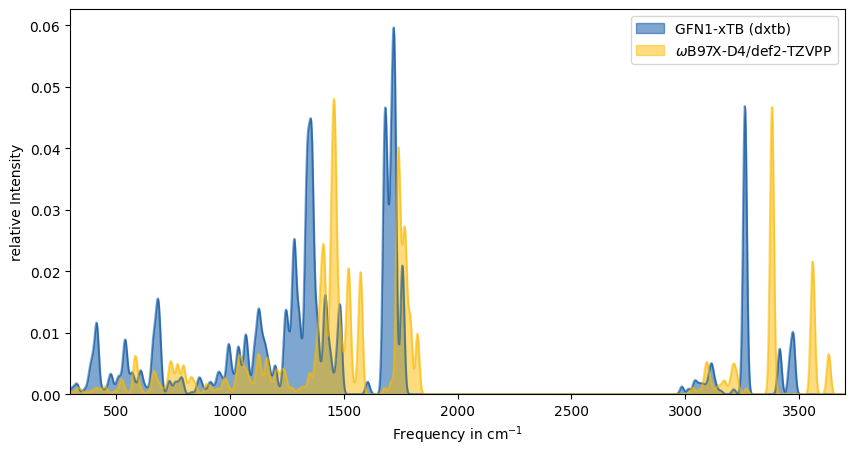

In [165]:
start = 300
end = 3700
width = 20.0
normalize = True
blue = "#004e9f"
yellow = "#fcba00"

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plot xtb data.
ints_taxol = ints_taxol / ints_taxol.max()
ints_taxol_dft = ints_taxol_dft / ints_taxol_dft.max()

freqs_taxol, ints_taxol = fold(
    freqs_taxol, ints_taxol, start=start, end=end, width=width, normalize=normalize
)
ax.plot(freqs_taxol, ints_taxol, color=blue, alpha=0.5)
ax.fill_between(freqs_taxol, ints_taxol, label="GFN1-xTB (dxtb)", color=blue, alpha=0.5)

freqs_taxol_dft, ints_taxol_dft = fold(
    freqs_taxol_dft,
    ints_taxol_dft,
    start=start,
    end=end,
    width=width,
    normalize=normalize,
)
ax.plot(freqs_taxol_dft, ints_taxol_dft, color=yellow, alpha=0.5)
ax.fill_between(
    freqs_taxol_dft,
    ints_taxol_dft,
    color=yellow,
    label=r"$\omega$B97X-D4/def2-TZVPP",
    alpha=0.5,
)

ax.set_xlim(start, end)
ax.set_ylim(0)

plt.xlabel("Frequency in cm$^{-1}$")
plt.ylabel("relative Intensity")
plt.legend(loc="upper right")
plt.show()


# PySCF

In [166]:
import pyscf

In [167]:
mol = dxtb.mol.external.M(numbers, positions)
mol.intor("int1e_rr").shape

(9, 12, 12)

In [168]:
quad = mol.intor('int1e_rr').reshape(3,3,mol.nao,mol.nao)
quad[0]

array([[[ 5.17694800e-02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  4.07377887e-02, -8.64692229e-03,
          4.07377887e-02, -8.64692229e-03,  4.07377887e-02,
         -8.64692229e-03,  4.07377887e-02, -8.64692229e-03],
        [ 0.00000000e+00,  3.20056392e-01,  0.00000000e+00,
          0.00000000e+00, -7.69644414e-02, -2.50264387e-02,
          7.69644414e-02,  2.50264387e-02,  7.69644414e-02,
          2.50264387e-02, -7.69644414e-02, -2.50264387e-02],
        [ 0.00000000e+00,  0.00000000e+00,  1.06685464e-01,
          0.00000000e+00, -3.48442093e-02, -9.01889339e-03,
          3.48442093e-02,  9.01889339e-03, -3.48442093e-02,
         -9.01889339e-03,  3.48442093e-02,  9.01889339e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.06685464e-01, -3.48442093e-02, -9.01889339e-03,
         -3.48442093e-02, -9.01889339e-03,  3.48442093e-02,
          9.01889339e-03,  3.48442093e-02,  9.01889339e-03],
        [ 4.07377887e-02, -7.6964441